In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
register_matplotlib_converters()
from time import time
import pylab
from data_parser_2 import insulin_correction
import statsmodels.api as sm

# Import meal data

In [219]:
original_data = pd.read_csv('data/cgm_to_meal_start.csv', parse_dates=['time_insulin', 'time_cgm'])
original_data = original_data.dropna()
original_data = original_data.reset_index(drop=True)

# do insulin correction
from data_parser_2 import insulin_correction
insulin_correction(original_data)

In [3]:
#read data
data = pd.read_csv('data/cgm_to_meal_start.csv', parse_dates=['time_insulin', 'time_cgm'])
data = data.dropna()
data = data.reset_index(drop=True)

# do insulin correction
from data_parser_2 import insulin_correction
insulin_correction(data)

data = data.loc[(data['meal'] == 0) & (data['meal_start'] == 0)]
data = data.reset_index(drop=True)
data.head()

,cgm,time_insulin,time_cgm,meal_start,meal
0,314.0,2017-07-25 12:03:28,2017-07-25 12:08:54,0,0
1,314.0,2017-07-25 12:03:51,2017-07-25 12:08:54,0,0
2,314.0,2017-07-25 12:03:55,2017-07-25 12:08:54,0,0
3,314.0,2017-07-25 12:05:53,2017-07-25 12:08:54,0,0
4,314.0,2017-07-25 12:05:53,2017-07-25 12:08:54,0,0


In [4]:
cgm = data['cgm'].to_numpy()

### plot the first 1000 points of the data

Text(0, 0.5, 'CGM values')

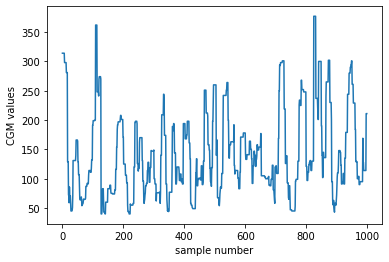

In [5]:
PLOT_POINTS = 1000
pylab.plot(cgm[:PLOT_POINTS])
pylab.xlabel('sample number')
pylab.ylabel('CGM values')

### ACF to compute Movind average (MA) parameters

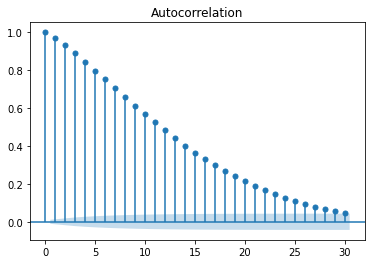

In [6]:
t1 = plot_acf(cgm, lags=30)

### PACF to compute Autoregression (AR) parameters

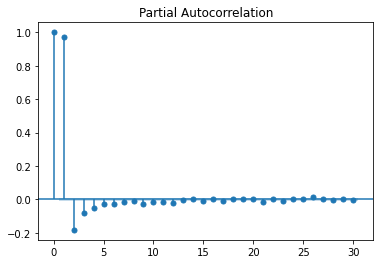

In [7]:
t1 = plot_pacf(cgm, lags=30)

### Fit the SARIMA Model

In [8]:
TRAIN_POINTS = 10000
train_data = cgm[:TRAIN_POINTS]
order = (5, 0, 20)

# we ingored seasonality as it gave bad results and increased compuation time
seasonal_order = (1, 0, 1, 400)
# define model
# model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model = SARIMAX(train_data, order=order)

#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

#summary of the model
print(model_fit.summary())

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model Fitting Time: 85.81633734703064
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:              SARIMAX(5, 0, 20)   Log Likelihood              -41259.398
Date:                Sun, 29 Nov 2020   AIC                          82570.797
Time:                        11:16:09   BIC                          82758.266
Sample:                             0   HQIC                         82634.254
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0318      0.074     -0.430      0.667      -0.177       0.113
ar.L2          1.0341      0.070     14.827      0.000       0.897       1.171
ar.L3         

### For Time-series data, one can only make predictions for few samples ahead in time

In [13]:
FORECAST_POINTS = 25
test_data = cgm[TRAIN_POINTS + 1 : TRAIN_POINTS + FORECAST_POINTS + 1]

#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
# predictions = model_fit.predict(2000, 2020)
predictions = np.array(predictions)
residuals = test_data - predictions

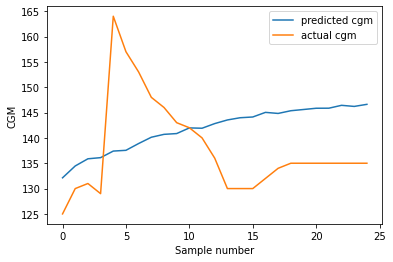

In [14]:
pylab.plot(predictions, label='predicted cgm')
pylab.plot(test_data, label='actual cgm')
pylab.xlabel('Sample number')
pylab.ylabel('CGM')
pylab.legend()

In [15]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.072
Root Mean Squared Error: 11.465334295889058


#### Evaluating the model
- First split the data into k consequtive subsets called folds
- Then split each fold into train and test-set

In [225]:
K = 20
data_per_fold = 5000
train_percent = 0.70
 
for fold_no in range(K):
    # select a random start index for the fold.
    fold_start_idx = np.random.randint(0, len(original_data) - data_per_fold - 1)
    
    fold_end_idx = fold_start_idx + data_per_fold
    fold_data = original_data[fold_start_idx : fold_end_idx]
    fold_train_end_idx = int(train_percent * fold_data.__len__())
    
    fold_train_data = fold_data[0 : fold_train_end_idx]
    fold_test_data = fold_data[fold_train_end_idx : ]
    
    # apply SARIMA model on the train data after removing meal points from it
    fold_train_data_no_meal = fold_train_data.loc[(fold_train_data['meal_start'] == 0) & (fold_train_data['meal'] == 0)]
    fold_cgm_train_no_meal = fold_train_data_no_meal['cgm'].to_numpy()
    
    # train the model
    order = (5, 0, 20)
    model = SARIMAX(fold_cgm_train_no_meal, order=order).fit()
    model_params = model.params
    
    fold_cgm_data = fold_data['cgm'].to_numpy()
    # now make a new model with the fitted values from the trained model
    predictor_model = sm.tsa.SARIMAX(fold_cgm_data, order=order)
    predictor_model = predictor_model.filter(model_params)
    
    predicted_cgm_values = predictor_model.predict()
    
    # compute meal and no-meal here
    
    meal_diff = []
    non_meal_diff = []
    meal_truth = (fold_data['meal_start'] == 1).to_numpy()
    meal_indices = np.where(meal_truth == True)[0]
    non_meal_indices = np.where(meal_truth == False)[0]

    for idx in meal_indices:
        meal_diff.append(abs(predicted_cgm_values[idx] - fold_cgm_data[idx]))

    for idx in non_meal_indices:
        non_meal_diff.append(abs(predicted_cgm_values[idx] - fold_cgm_data[idx]))
    
    meal_diff = np.array(meal_diff)
    non_meal_diff = np.array(non_meal_diff)
    
    print("#" * 10)
    threshold = 4.5
    non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
    meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]
    
    true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
    true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()
    
    false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
    false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()
    
    print("TP ", true_positive, "FP ", false_positive, "TN ", true_negative, "FN ", false_negative)
    print("accuracy: ", (non_meal_row[0] + meal_row[1]) / (non_meal_row[0] + meal_row[1] + non_meal_row[1] + meal_row[0]) )
    print("#" * 10)

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.3595505617977528 FP  0.3380166972103441 TN  0.6619833027896559 FN  0.6404494382022472
accuracy:  0.6566
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.3548387096774194 FP  0.331567148970858 TN  0.6684328510291421 FN  0.6451612903225806
accuracy:  0.6626
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.4125 FP  0.3416666666666667 TN  0.6583333333333333 FN  0.5875
accuracy:  0.6544
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.21505376344086022 FP  0.31567148970857956 TN  0.6843285102914204 FN  0.7849462365591398
accuracy:  0.6756
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.2127659574468085 FP  0.3226661231145536 TN  0.6773338768854464 FN  0.7872340425531915
accuracy:  0.6686
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.24444444444444444 FP  0.3323828920570265 TN  0.6676171079429736 FN  0.7555555555555555
accuracy:  0.66
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.36363636363636365 FP  0.38925081433224756 TN  0.6107491856677525 FN  0.6363636363636364
accuracy:  0.6064
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.41284403669724773 FP  0.3802903291760376 TN  0.6197096708239623 FN  0.5871559633027523
accuracy:  0.6152
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.4146341463414634 FP  0.332452216348109 TN  0.667547783651891 FN  0.5853658536585366
accuracy:  0.6634
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.35064935064935066 FP  0.3351614868982328 TN  0.6648385131017672 FN  0.6493506493506493
accuracy:  0.66
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.24358974358974358 FP  0.3392929703372613 TN  0.6607070296627388 FN  0.7564102564102564
accuracy:  0.6542
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.38636363636363635 FP  0.37886807817589574 TN  0.6211319218241043 FN  0.6136363636363636
accuracy:  0.617
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.35555555555555557 FP  0.3725050916496945 TN  0.6274949083503055 FN  0.6444444444444445
accuracy:  0.6226
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.3263157894736842 FP  0.3202854230377166 TN  0.6797145769622834 FN  0.6736842105263158
accuracy:  0.673
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.34444444444444444 FP  0.3334012219959267 TN  0.6665987780040733 FN  0.6555555555555556
accuracy:  0.6608
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.38095238095238093 FP  0.3810008136696501 TN  0.6189991863303499 FN  0.6190476190476191
accuracy:  0.615
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.4567901234567901 FP  0.36450498068713155 TN  0.6354950193128684 FN  0.5432098765432098
accuracy:  0.6326
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.4222222222222222 FP  0.3940936863543788 TN  0.6059063136456212 FN  0.5777777777777777
accuracy:  0.6026
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.2962962962962963 FP  0.3588127668225249 TN  0.6411872331774751 FN  0.7037037037037037
accuracy:  0.6356
##########


c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##########
TP  0.38095238095238093 FP  0.37591537835638733 TN  0.6240846216436127 FN  0.6190476190476191
accuracy:  0.62
##########


Non meal predicted correctly:  680
Non meal predicted wrongly:  226
Meal predicted correctly:  41
Meal predicted wrongly:  83
accuracy 0.7


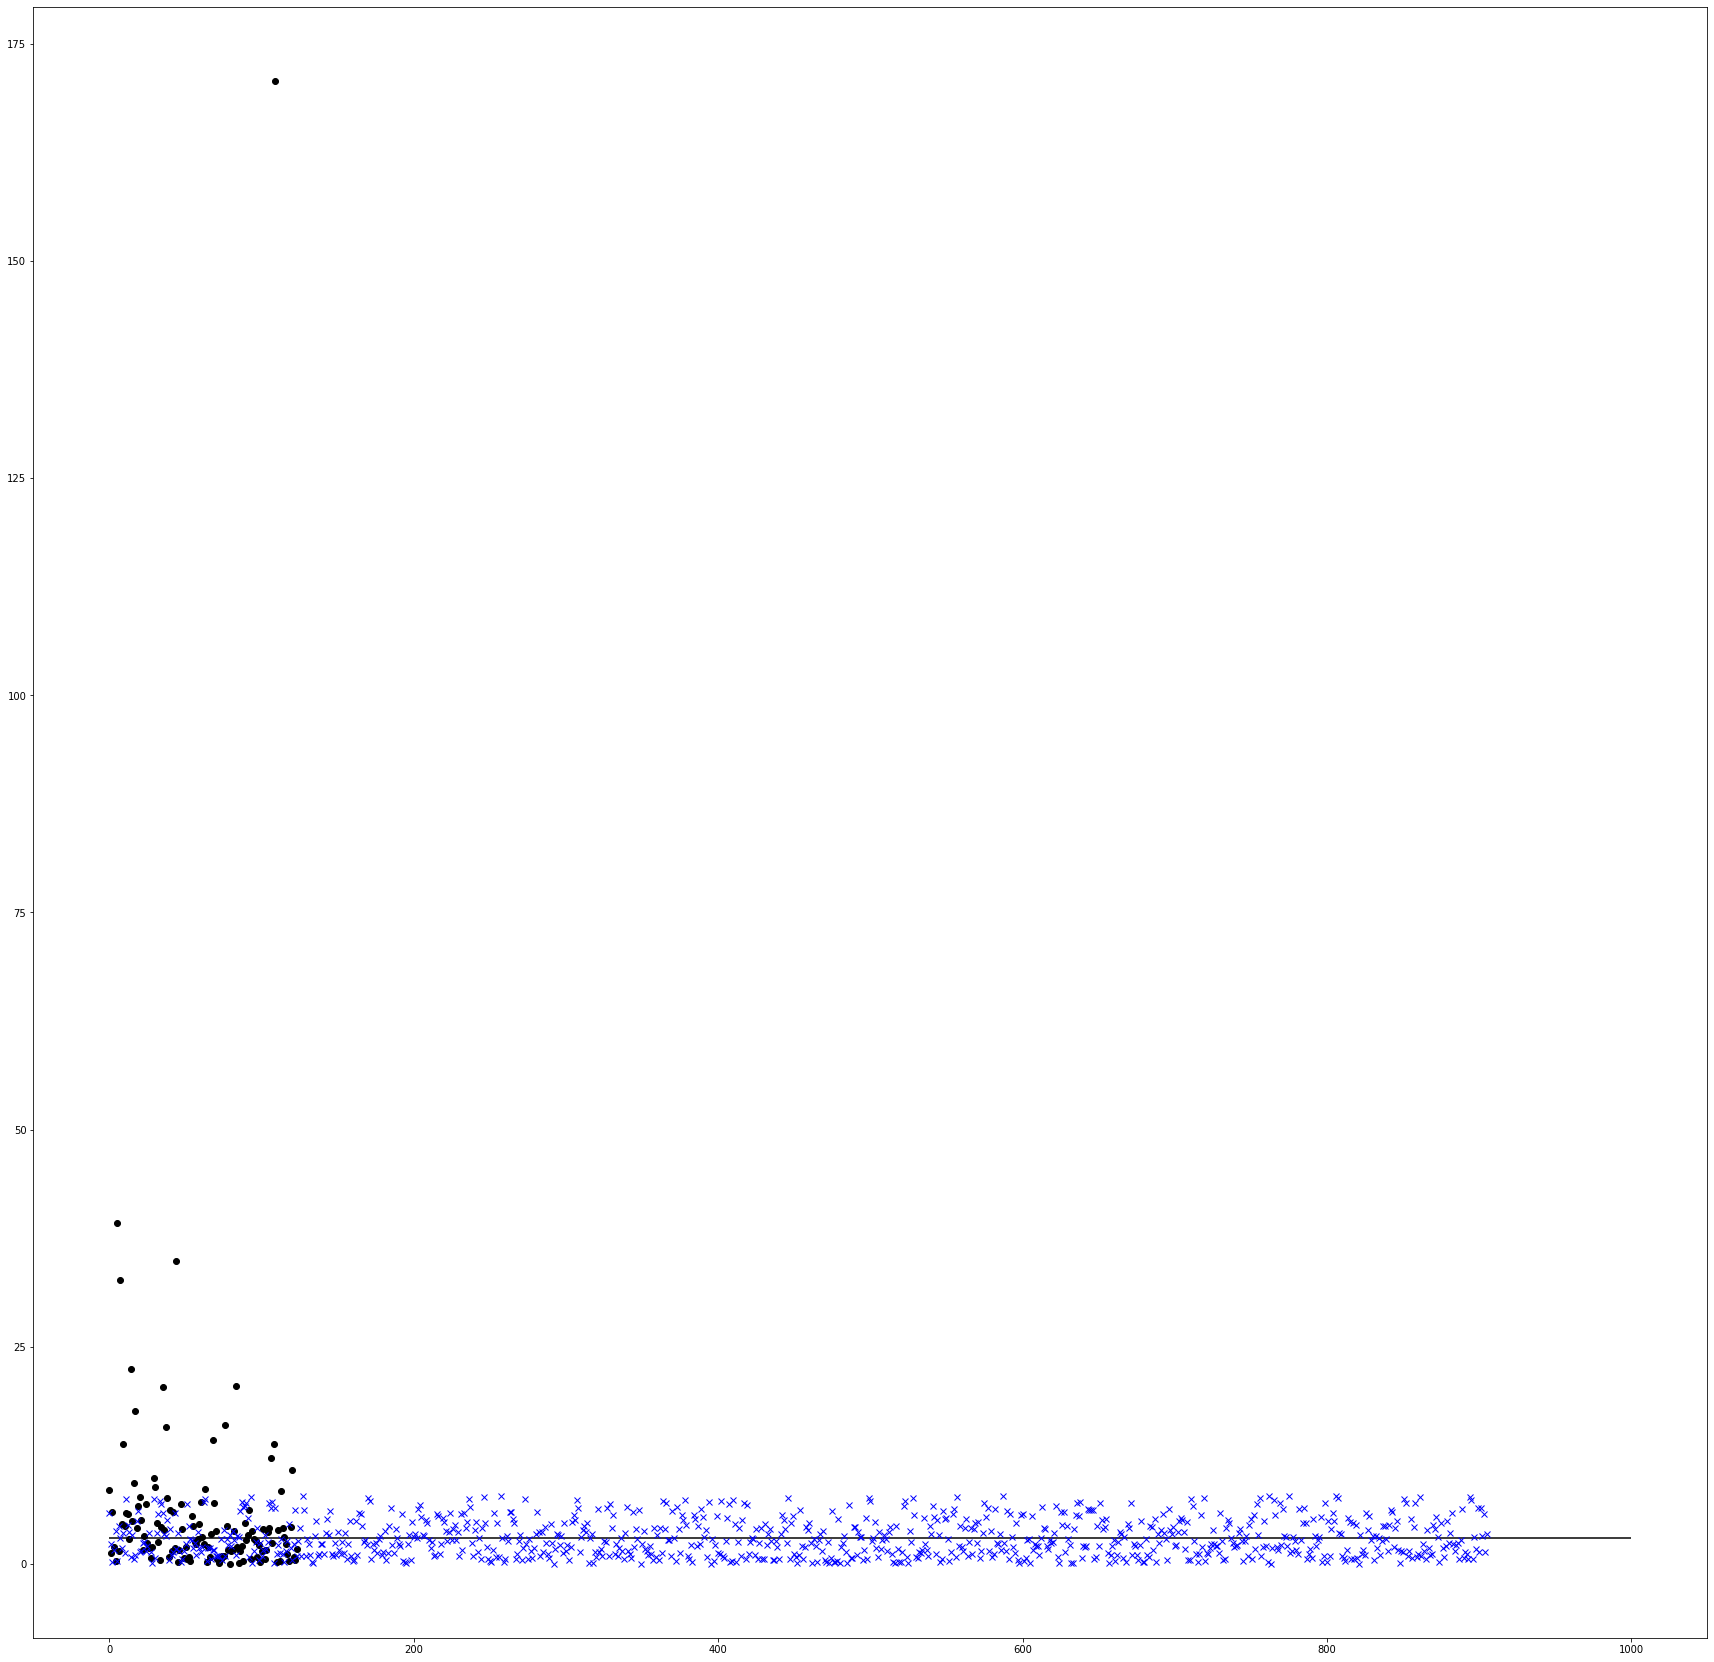

In [216]:
meal_diff = np.array(meal_diff)
non_meal_diff = np.array(non_meal_diff)

non_meal_diff = reject_outliers(non_meal_diff)
# non_meal_diff = np.random.choice(non_meal_diff, 1000, replace=False)

plt.figure(figsize=(30, 30))
plt.plot(meal_diff, 'o', color='black')
plt.plot(non_meal_diff, 'x', color='blue')
plt.hlines(3.0, 0, 1000, color='black')

threshold = 4.5
non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]
print("Non meal predicted correctly: ", non_meal_row[0])
print("Non meal predicted wrongly: ", non_meal_row[1])
print("Meal predicted correctly: ", meal_row[1])
print("Meal predicted wrongly: ", meal_row[0])

print("accuracy", (non_meal_row[0] + meal_row[1]) / (non_meal_row[0] + meal_row[1] + non_meal_row[1] + meal_row[0]) )

Non meal predicted correctly:  680
Non meal predicted wrongly:  320
Meal predicted correctly:  41
Meal predicted wrongly:  83
accuracy 0.641459074733096


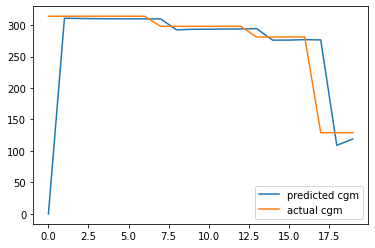

In [214]:
# model.summary()
# FORECAST_POINTS = 10
# test_data = fold_test_data[:FORECAST_POINTS]['cgm'].to_numpy()

# #get the predictions and residuals
# predictions = model.forecast(len(test_data))
# # predictions = model_fit.predict(2000, 2020)
# predictions = np.array(predictions)
# residuals = test_data - predictions

# pylab.plot(predictions, label='predicted cgm')
# pylab.plot(test_data, label='actual cgm')
# pylab.xlabel('Sample number')
# pylab.ylabel('CGM')
# pylab.legend()

predictor_model = sm.tsa.SARIMAX(fold_cgm_data, order=order)
predictor_model = predictor_model.filter(model_params)
predicted_cgm_values = predictor_model.predict()

pylab.plot(predicted_cgm_values[:20], label='predicted cgm')
pylab.plot(fold_cgm_data[:20], label='actual cgm')
pylab.legend()



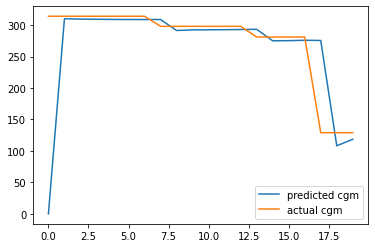

#### Example loop

7726

#### Temporary code

In [ ]:
import statsmodels.api as sm
model_fit.params

In [ ]:
# training_mod = sm.tsa.SARIMAX(train_data, order=(5,0,20))
# training_res = training_mod.fit()

In [ ]:
NEW_FORECAST_POINTS = 10
new_train_data = cgm[0 : TRAIN_POINTS + FORECAST_POINTS + 1 - NEW_FORECAST_POINTS]
mod = sm.tsa.SARIMAX(new_train_data, order=(10,0,30))
res = mod.filter(model_fit.params)
# insample = res.predict()
# T = len(dta.realgdp.ix['2000-01-01':])
# forecast_error = dta.realgdp.ix['2000-01-01':] - insample.ix['2000-01-01':]
# print(np.sqrt(np.sum(forecast_error**2) / T))

In [ ]:
mod_predictions = res.forecast(NEW_FORECAST_POINTS)

In [ ]:
test_data[-NEW_FORECAST_POINTS:]

In [ ]:
mod_predictions

#### Finding the threshold

In [64]:
# train on entire model
original_cgm_meal = original_data.loc[(original_data['meal'] == 0) & (original_data['meal_start'] == 0)]['cgm'].to_numpy()

order = (5, 0, 20)
model = SARIMAX(original_cgm_meal, order=order).fit()
model_params = model.params

model.summary()

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                34081
Model:              SARIMAX(5, 0, 20)   Log Likelihood             -139105.539
Date:                Sun, 29 Nov 2020   AIC                         278263.077
Time:                        12:21:44   BIC                         278482.426
Sample:                             0   HQIC                        278333.033
                              - 34081                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9709      0.036    -26.777      0.000      -1.042      -0.900
ar.L2          1.7669      0.015    119.492      0.000       1.738       1.796
ar.L3          1.8268      0.064     28.527      0.000       1.701       1.952
ar.L4         -0.7699      0.015    -50.442      0.000      -0.800      -0.740
ar.L5         -0.8528      0.031    -27.752      0.000      -0.913      -0.793
ma.L1          2.1041      0.036     57.654      0.000       2.033       2.176
ma.L2          0.5162      0.048     10.721      0.000       0.422       0.611
ma.L3         -1.4789      0.028    -52.926      0.000      -1.534      -1.424
ma.L4         -1.0374      0.034    -30.226      0.000      -1.105      -0.970
ma.L5         -0.2407      0.014    -17.323      0.000      -0.268      -0.213
ma.L6         -0.1482      0.014    -10.292      0.000      -0.176      -0.120
ma.L7         -0.1030      0.014     -7.167      0.000      -0.131      -0.075
ma.L8         -0.0762      0.013     -5.707      0.000      -0.102      -0.050
ma.L9         -0.0385      0.015     -2.531      0.011      -0.068      -0.009
ma.L10        -0.0293      0.014     -2.043      0.041      -0.057      -0.001
ma.L11        -0.0384      0.014     -2.682      0.007      -0.066      -0.010
ma.L12        -0.0343      0.014     -2.385      0.017      -0.062      -0.006
ma.L13        -0.0565      0.015     -3.855      0.000      -0.085      -0.028
ma.L14        -0.0713      0.014     -5.137      0.000      -0.098      -0.044
ma.L15        -0.0472      0.016     -2.992      0.003      -0.078      -0.016
ma.L16        -0.0339      0.014     -2.492      0.013      -0.060      -0.007
ma.L17        -0.0414      0.015     -2.802      0.005      -0.070      -0.012
ma.L18        -0.0480      0.014     -3.514      0.000      -0.075      -0.021
ma.L19        -0.0351      0.013     -2.748      0.006      -0.060      -0.010
ma.L20        -0.0104      0.005     -1.896      0.058      -0.021       0.000
sigma2       204.6641      0.415    493.573      0.000     203.851     205.477
===================================================================================
Ljung-Box (Q):                       41.69   Jarque-Bera (JB):           4575163.68
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
original_cgm = original_data['cgm'].to_numpy()
predictor = sm.tsa.SARIMAX(original_cgm, order=order)
predictor = predictor.filter(model_params)

cgm_predictions = predictor.predict()

In [202]:
import random

def reject_outliers(data, m=2):
    t1 = abs(data - np.mean(data)) < m * np.std(data)
    return data[(np.where(t1 == True))[0]]
    
meal_diff = []
non_meal_diff = []
meal_truth = (original_data['meal_start'] == 1).to_numpy()
meal_indices = np.where(meal_truth == True)[0]
non_meal_indices = np.where(meal_truth == False)[0]

for idx in meal_indices:
    meal_diff.append(abs(cgm_predictions[idx] - original_cgm[idx]))

for idx in non_meal_indices:
    non_meal_diff.append(abs(cgm_predictions[idx] - original_cgm[idx]))

meal_diff = np.array(meal_diff)
non_meal_diff = np.array(non_meal_diff)

non_meal_diff = reject_outliers(non_meal_diff)
non_meal_diff = np.random.choice(non_meal_diff, 4000, replace=False)

In [203]:
from scipy.stats import describe
describe(meal_diff)

DescribeResult(nobs=694, minmax=(0.0028438929309970717, 167.23954394917175), mean=5.947962283375802, variance=147.60529172277342, skewness=7.34964335418872, kurtosis=73.21364501591174)

In [204]:
describe(non_meal_diff)

DescribeResult(nobs=4000, minmax=(0.0013351456944690199, 29.00755214253359), mean=4.293656534569091, variance=21.542941436434162, skewness=2.35329102263044, kurtosis=6.756815753070359)

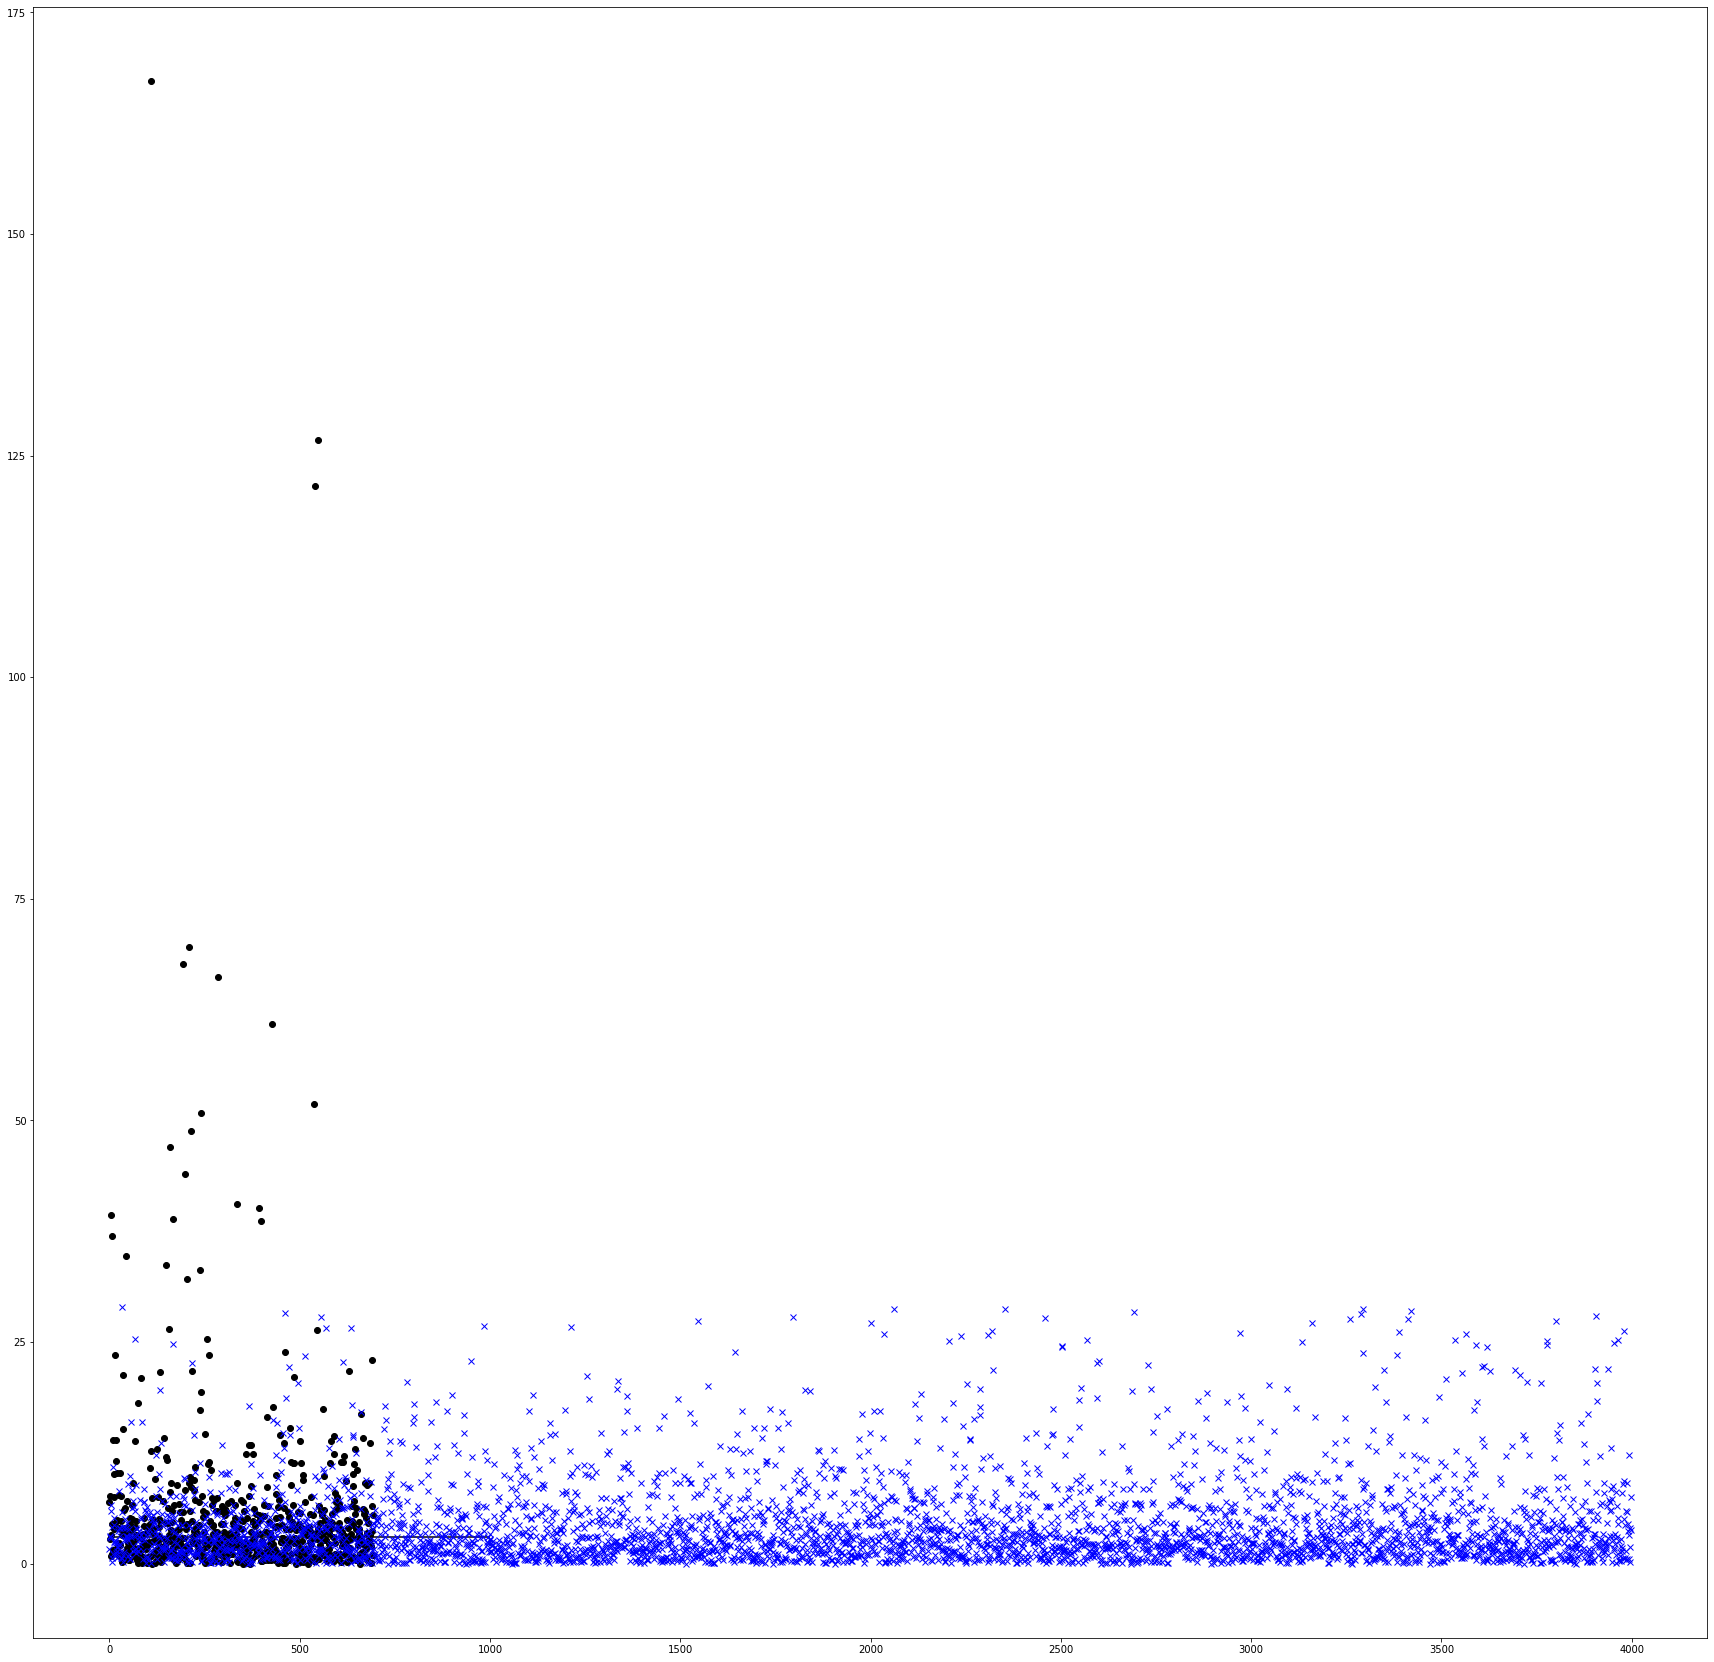

In [205]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.plot(meal_diff, 'o', color='black')
plt.plot(non_meal_diff, 'x', color='blue')
plt.hlines(3.0, 0, 1000, color='black')

In [209]:
threshold = 4.5
non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]
print("Non meal predicted correctly: ", non_meal_row[0])
print("Non meal predicted wrongly: ", non_meal_row[1])
print("Meal predicted correctly: ", meal_row[1])
print("Meal predicted wrongly: ", meal_row[0])

print("accuracy", (non_meal_row[0] + meal_row[1]) / (non_meal_row[0] + meal_row[1] + non_meal_row[1] + meal_row[0]) )

Non meal predicted correctly:  2729
Non meal predicted wrongly:  1271
Meal predicted correctly:  237
Meal predicted wrongly:  457
accuracy 0.6318704729441841


In [181]:
t1 = np.array([1,2,3,4])
t1[[True, True, False, False]]

array([1, 2])